In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
PROCESSED_PATH = PROJECT_ROOT / 'data/processed/application_features_baseline.csv'
RANDOM_SEED = 42

In [3]:
df = pd.read_csv(PROCESSED_PATH)

X = df.drop(columns='TARGET')
y = df['TARGET']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    stratify=y, 
    random_state=RANDOM_SEED
    )

In [5]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 18619, number of negative: 212014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2865
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_estimators=300, n_jobs=-1, random_state=42,
               subsample=0.8)

In [8]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score

pred_proba = lgb_model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, pred_proba)

roc_auc

np.float64(0.7488086333812225)

In [10]:
thresholds = np.linspace(0.1, 0.9, 9)
res = []

for t in thresholds:
    pred = (pred_proba >= t).astype(int)

    res.append({
        'threshold': t,
        'recall': recall_score(y_val, pred),
        'precision': precision_score(y_val, pred)
    })

pd.DataFrame(res)

,threshold,recall,precision
0,0.1,0.995166,0.082642
1,0.2,0.965034,0.093558
2,0.3,0.897680,0.111666
3,0.4,0.797776,0.134912
4,0.5,0.661940,0.164195
5,0.6,0.504673,0.205229
6,0.7,0.320819,0.263360
7,0.8,0.137286,0.370274
8,0.9,0.009346,0.610526


LightGBM improves ROC-AUC by ~1.3% compared to Logistic Regression, precision is higher with the same recall, this means that model has a higher approval rate with the same defaulter capture ability.

In [12]:
feature_importance = pd.Series(
    lgb_model.booster_.feature_importance(importance_type='gain'),
    index=X_train.columns
).sort_values(ascending=False)

feature_importance_normalized = feature_importance / feature_importance.sum()
feature_importance_normalized

EXT_SOURCE_3                   0.288882
EXT_SOURCE_2                   0.244516
EXT_SOURCE_1                   0.096816
age_years                      0.063719
log_credit                     0.051315
employed_years                 0.047528
annuity_income_ratio           0.034112
id_published_years             0.031751
credit_income_ratio            0.025131
registration_years             0.024283
flag_gender                    0.024106
REGION_POPULATION_RELATIVE     0.018809
log_income                     0.016723
flag_car                       0.013071
REGION_RATING_CLIENT_W_CITY    0.011006
CNT_FAM_MEMBERS                0.007309
ext_source_1_missing           0.000437
ext_source_3_missing           0.000393
has_many_children              0.000094
days_employed_missing          0.000000
dtype: float64

<Axes: title={'center': 'LightGBM feature importance (Gain)'}>

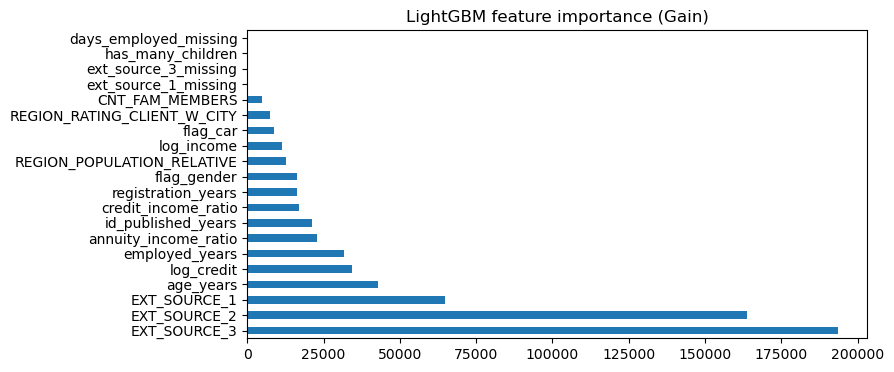

In [ ]:
feature_importance.plot(
    kind='barh',
    figsize=(8,4),
    title='LightGBM feature importance (Gain)'
);

LightGBM relies most on EXT_SOURCE_* features as they gain the most values, same behaviour as in Logistic Regression. Explicit missing values indicators don't contribute much because of LightGBM's native missing handling. In conclusion feature importance doesn't show any artifacts.